## XGBoost - sensor stability - 2bins - 50/50

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")

In [2]:
df = pd.read_csv(f"../StabilityGasSensors_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sensor                   19 non-null     object 
 1   dopant_type              19 non-null     object 
 2   dopant_dose              19 non-null     float64
 3   calcination_temperature  19 non-null     object 
 4   BET_fresh                19 non-null     float64
 5   particle_size_fresh      19 non-null     float64
 6   BET_aged                 19 non-null     float64
 7   particle_size_aged       19 non-null     float64
 8   fresh_point              19 non-null     float64
 9   5th_day                  19 non-null     float64
 10  8th_day                  16 non-null     float64
 11  12th_day                 18 non-null     float64
 12  15th_day                 19 non-null     float64
 13  diff_5_15day             19 non-null     float64
 14  diff_5_15day_5050        19 

In [4]:
df["dopant_type"].unique()

array(['no dopant', 'Mo', 'Ce', 'Sm', 'Si'], dtype=object)

In [5]:
df["calcination_temperature"].unique()

array(['no calcination', '700', '850'], dtype=object)

In [6]:
target = "diff_5_15day_5050"
representation = ["dopant_type", "dopant_dose", "calcination_temperature"]
random_state=42
train_size=10

In [7]:
encoder_dopant = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_dopant.fit_transform(df[["dopant_type"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [8]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant'],
      dtype='object')

In [9]:
encoder_temp = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder_temp.fit_transform(df[["calcination_temperature"]])
df = pd.concat([df, one_hot_encoded], axis=1)

In [10]:
df.columns

Index(['sensor', 'dopant_type', 'dopant_dose', 'calcination_temperature',
       'BET_fresh', 'particle_size_fresh', 'BET_aged', 'particle_size_aged',
       'fresh_point', '5th_day', '8th_day', '12th_day', '15th_day',
       'diff_0_5day', 'diff_0_5day_binned', 'diff_5_15day',
       'diff_5_15day_2bins', 'diff_5_15day_3bins', 'diff_5_15day_5050',
       'synthesis', 'synthesis_BET', 'dopant_type_Ce', 'dopant_type_Mo',
       'dopant_type_Si', 'dopant_type_Sm', 'dopant_type_no dopant',
       'calcination_temperature_700', 'calcination_temperature_850',
       'calcination_temperature_no calcination'],
      dtype='object')

In [11]:
df.columns[21:30].to_list()

['dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [12]:
representation = ["dopant_dose"]
representation.extend(df.columns[21:30].to_list())

In [13]:
representation

['dopant_dose',
 'dopant_type_Ce',
 'dopant_type_Mo',
 'dopant_type_Si',
 'dopant_type_Sm',
 'dopant_type_no dopant',
 'calcination_temperature_700',
 'calcination_temperature_850',
 'calcination_temperature_no calcination']

In [14]:
def prepare_dataset_classification(
    df,
    target = "diff_5_15day_5050",
    representation = representation,
    random_state=42,
    train_size=10
):
    df_train, df_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )

    print(len(df_train), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return X_train, y_train, X_test, y_test

In [15]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=100, 
        random_state=random_state, 
        #early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [16]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 5

In [17]:
train_size = 5
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [18]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
5 14
random_state = 42
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 2/10
5 14
random_state = 43
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 3/10
5 14
random_state = 44
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 4/10
5 14
random_state = 45
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 5/10
5 14
random_state = 46
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 6/10
5 14
random_state = 47
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 7/10
5 14
random_state = 48
Accuracy: 0.5
F1 macro: 0.3333333333333333


In [19]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 5
mean accuracy: 0.5 +/- 0.0
mean F1 macro: 0.33333333333333337 +/- 5.551115123125783e-17
mean F1 micro: 0.5 +/- 0.0
mean F1 weighted: 0.33333333333333337 +/- 5.551115123125783e-17
mean Kappa: 0.0 +/- 0.0


In [20]:
compiled_res_5 = pd.DataFrame(metrics_dict())
compiled_res_5.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
1,5,"[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
2,5,"[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0


### training size = 8

In [21]:
train_size = 8
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [22]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
8 11
random_state = 42
Accuracy: 0.5454545454545454
F1 macro: 0.35294117647058826
F1 micro: 0.5454545454545454
F1 weighted: 0.3850267379679144
Kappa: 0.0
-------------Iteration 2/10
8 11
random_state = 43
Accuracy: 0.5454545454545454
F1 macro: 0.35294117647058826
F1 micro: 0.5454545454545454
F1 weighted: 0.3850267379679144
Kappa: 0.0
-------------Iteration 3/10
8 11
random_state = 44
Accuracy: 0.5454545454545454
F1 macro: 0.35294117647058826
F1 micro: 0.5454545454545454
F1 weighted: 0.3850267379679144
Kappa: 0.0
-------------Iteration 4/10
8 11
random_state = 45
Accuracy: 0.5454545454545454
F1 macro: 0.35294117647058826
F1 micro: 0.5454545454545454
F1 weighted: 0.3850267379679144
Kappa: 0.0
-------------Iteration 5/10
8 11
random_state = 46
Accuracy: 0.45454545454545453
F1 macro: 0.45
F1 micro: 0.45454545454545453
F1 weighted: 0.45454545454545453
Kappa: -0.10000000000000009
-------------Iteration 6/10
8 11
random_state = 47
Accuracy: 0.5454545454545454
F1 ma

In [23]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 8
mean accuracy: 0.5181818181818182 +/- 0.05821022034029861
mean F1 macro: 0.3615409753645048 +/- 0.029670173367522142
mean F1 micro: 0.5181818181818182 +/- 0.05821022034029861
mean F1 weighted: 0.38875177110471226 +/- 0.02394857390309199
mean Kappa: -0.0405084745762712 +/- 0.09309529363621691


In [24]:
compiled_res_8 = pd.DataFrame(metrics_dict())
compiled_res_8.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,8,"[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.545455,0.352941,0.545455,0.385027,0.0
1,8,"[0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.545455,0.352941,0.545455,0.385027,0.0
2,8,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.545455,0.352941,0.545455,0.385027,0.0


### training size = 10

In [25]:
train_size = 10
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [26]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
10 9
random_state = 42
Accuracy: 0.5555555555555556
F1 macro: 0.35714285714285715
F1 micro: 0.5555555555555556
F1 weighted: 0.39682539682539686
Kappa: 0.0
-------------Iteration 2/10
10 9
random_state = 43
Accuracy: 0.3333333333333333
F1 macro: 0.325
F1 micro: 0.3333333333333333
F1 weighted: 0.3333333333333333
Kappa: -0.34999999999999987
-------------Iteration 3/10
10 9
random_state = 44
Accuracy: 0.3333333333333333
F1 macro: 0.325
F1 micro: 0.3333333333333333
F1 weighted: 0.3333333333333333
Kappa: -0.34999999999999987
-------------Iteration 4/10
10 9
random_state = 45
Accuracy: 0.5555555555555556
F1 macro: 0.35714285714285715
F1 micro: 0.5555555555555556
F1 weighted: 0.39682539682539686
Kappa: 0.0
-------------Iteration 5/10
10 9
random_state = 46
Accuracy: 0.4444444444444444
F1 macro: 0.41558441558441556
F1 micro: 0.4444444444444444
F1 weighted: 0.43001443001442996
Kappa: -0.15384615384615397
-------------Iteration 6/10
10 9
random_state = 47
Accuracy: 0.1

In [27]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 10
mean accuracy: 0.4 +/- 0.14229164972073
mean F1 macro: 0.33753690753690757 +/- 0.11358630486824492
mean F1 micro: 0.4 +/- 0.14229164972073
mean F1 weighted: 0.34827394827394825 +/- 0.11798955925291976
mean Kappa: -0.2244277673545966 +/- 0.2695520182371343


In [28]:
compiled_res_10 = pd.DataFrame(metrics_dict())
compiled_res_10.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,10,"[0, 1, 1, 0, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.555556,0.357143,0.555556,0.396825,0.00
1,10,"[0, 0, 0, 1, 1, 1, 1, 0, 0]","[0, 0, 1, 0, 0, 0, 1, 1, 1]",0.333333,0.325000,0.333333,0.333333,-0.35
2,10,"[1, 1, 1, 0, 0, 0, 0, 0, 1]","[0, 0, 1, 1, 1, 0, 1, 0, 0]",0.333333,0.325000,0.333333,0.333333,-0.35


### training size = 12

In [29]:
train_size = 12
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [30]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
12 7
random_state = 42
Accuracy: 0.5714285714285714
F1 macro: 0.5714285714285714
F1 micro: 0.5714285714285714
F1 weighted: 0.5714285714285714
Kappa: 0.15999999999999992
-------------Iteration 2/10
12 7
random_state = 43
Accuracy: 0.2857142857142857
F1 macro: 0.2222222222222222
F1 micro: 0.2857142857142857
F1 weighted: 0.25396825396825395
Kappa: -0.5217391304347827
-------------Iteration 3/10
12 7
random_state = 44
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -0.9600000000000002
-------------Iteration 4/10
12 7
random_state = 45
Accuracy: 0.14285714285714285
F1 macro: 0.125
F1 micro: 0.14285714285714285
F1 weighted: 0.10714285714285714
Kappa: -0.6153846153846154
-------------Iteration 5/10
12 7
random_state = 46
Accuracy: 0.5714285714285714
F1 macro: 0.36363636363636365
F1 micro: 0.5714285714285714
F1 weighted: 0.4155844155844156
Kappa: 0.0
-------------Iteration 6/10
12 7
random_state = 47
Accuracy: 0.14285714285714285
F1 macro: 0.125
F1

In [31]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 12
mean accuracy: 0.2714285714285714 +/- 0.1857142857142857
mean F1 macro: 0.2296176046176046 +/- 0.16321645655698636
mean F1 micro: 0.2714285714285714 +/- 0.1857142857142857
mean F1 weighted: 0.24235209235209237 +/- 0.16980706100936174
mean Kappa: -0.4740914158305463 +/- 0.3397309173880833


In [32]:
compiled_res_12 = pd.DataFrame(metrics_dict())
compiled_res_12.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,12,"[0, 1, 0, 1, 0, 0, 1]","[0, 1, 1, 1, 0, 1, 0]",0.571429,0.571429,0.571429,0.571429,0.160000
1,12,"[0, 0, 1, 0, 1, 0, 1]","[0, 1, 0, 1, 0, 0, 0]",0.285714,0.222222,0.285714,0.253968,-0.521739
2,12,"[1, 1, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 1, 1, 1]",0.000000,0.000000,0.000000,0.000000,-0.960000


### training size = 13

In [33]:
train_size = 13
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [34]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
13 6
random_state = 42
Accuracy: 0.5
F1 macro: 0.4857142857142857
F1 micro: 0.5
F1 weighted: 0.48571428571428577
Kappa: 0.0
-------------Iteration 2/10
13 6
random_state = 43
Accuracy: 0.16666666666666666
F1 macro: 0.14285714285714285
F1 micro: 0.16666666666666666
F1 weighted: 0.14285714285714285
Kappa: -0.6666666666666667
-------------Iteration 3/10
13 6
random_state = 44
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -1.0
-------------Iteration 4/10
13 6
random_state = 45
Accuracy: 0.3333333333333333
F1 macro: 0.25
F1 micro: 0.3333333333333333
F1 weighted: 0.25
Kappa: -0.33333333333333326
-------------Iteration 5/10
13 6
random_state = 46
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 6/10
13 6
random_state = 47
Accuracy: 0.16666666666666666
F1 macro: 0.14285714285714285
F1 micro: 0.16666666666666666
F1 weighted: 0.14285714285714285
Kappa: -0.6666666666666667
---

In [35]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 13
mean accuracy: 0.2833333333333333 +/- 0.1674979270186815
mean F1 macro: 0.2307142857142857 +/- 0.1345709988871919
mean F1 micro: 0.2833333333333333 +/- 0.1674979270186815
mean F1 weighted: 0.2307142857142857 +/- 0.1345709988871919
mean Kappa: -0.4333333333333334 +/- 0.33499585403736304


In [36]:
compiled_res_13 = pd.DataFrame(metrics_dict())
compiled_res_13.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,13,"[0, 0, 1, 0, 1, 1]","[1, 1, 1, 0, 0, 1]",0.500000,0.485714,0.500000,0.485714,0.000000
1,13,"[0, 0, 1, 1, 1, 0]","[1, 1, 0, 0, 0, 0]",0.166667,0.142857,0.166667,0.142857,-0.666667
2,13,"[1, 1, 1, 0, 0, 0]","[0, 0, 0, 1, 1, 1]",0.000000,0.000000,0.000000,0.000000,-1.000000


### training size = 14

In [37]:
train_size = 14
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [38]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
14 5
random_state = 42
Accuracy: 0.6
F1 macro: 0.5833333333333333
F1 micro: 0.6
F1 weighted: 0.5666666666666667
Kappa: 0.2857142857142857
-------------Iteration 2/10
14 5
random_state = 43
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -0.9230769230769229
-------------Iteration 3/10
14 5
random_state = 44
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -0.9230769230769229
-------------Iteration 4/10
14 5
random_state = 45
Accuracy: 0.4
F1 macro: 0.2857142857142857
F1 micro: 0.4
F1 weighted: 0.22857142857142856
Kappa: 0.0
-------------Iteration 5/10
14 5
random_state = 46
Accuracy: 0.6
F1 macro: 0.375
F1 micro: 0.6
F1 weighted: 0.45
Kappa: 0.0
-------------Iteration 6/10
14 5
random_state = 47
Accuracy: 0.2
F1 macro: 0.16666666666666666
F1 micro: 0.2
F1 weighted: 0.2
Kappa: -0.6666666666666667
-------------Iteration 7/10
14 5
random_state = 48
Accuracy: 0.4
F1 macro: 0.4
F1 micro: 0.4
F1 weighted: 0.4
Kappa: -0.15384615384

In [39]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 14
mean accuracy: 0.26000000000000006 +/- 0.22
mean F1 macro: 0.2144047619047619 +/- 0.1860577181677662
mean F1 micro: 0.26000000000000006 +/- 0.22
mean F1 weighted: 0.22452380952380951 +/- 0.18754908654521776
mean Kappa: -0.4637362637362637 +/- 0.4294571480553789


In [40]:
compiled_res_14 = pd.DataFrame(metrics_dict())
compiled_res_14.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,14,"[0, 0, 1, 1, 0]","[0, 1, 1, 1, 1]",0.6,0.583333,0.6,0.566667,0.285714
1,14,"[0, 0, 0, 1, 1]","[1, 1, 1, 0, 0]",0.0,0.000000,0.0,0.000000,-0.923077
2,14,"[1, 0, 0, 1, 0]","[0, 1, 1, 0, 1]",0.0,0.000000,0.0,0.000000,-0.923077


### training size = 15

In [41]:
train_size = 15
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [42]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
15 4
random_state = 42
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 2/10
15 4
random_state = 43
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -1.0
-------------Iteration 3/10
15 4
random_state = 44
Accuracy: 0.0
F1 macro: 0.0
F1 micro: 0.0
F1 weighted: 0.0
Kappa: -1.0
-------------Iteration 4/10
15 4
random_state = 45
Accuracy: 0.5
F1 macro: 0.5
F1 micro: 0.5
F1 weighted: 0.5
Kappa: 0.0
-------------Iteration 5/10
15 4
random_state = 46
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 6/10
15 4
random_state = 47
Accuracy: 0.5
F1 macro: 0.3333333333333333
F1 micro: 0.5
F1 weighted: 0.3333333333333333
Kappa: 0.0
-------------Iteration 7/10
15 4
random_state = 48
Accuracy: 0.5
F1 macro: 0.5
F1 micro: 0.5
F1 weighted: 0.5
Kappa: 0.0
-------------Iteration 8/10
15 4
random_state = 49
Accuracy: 

In [43]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 15
mean accuracy: 0.3 +/- 0.2179449471770337
mean F1 macro: 0.24000000000000005 +/- 0.18366636418607882
mean F1 micro: 0.3 +/- 0.2179449471770337
mean F1 weighted: 0.24000000000000005 +/- 0.18366636418607882
mean Kappa: -0.4 +/- 0.4358898943540674


In [44]:
compiled_res_15 = pd.DataFrame(metrics_dict())
compiled_res_15.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,15,"[0, 0, 1, 1]","[1, 1, 1, 1]",0.5,0.333333,0.5,0.333333,0.0
1,15,"[0, 1, 1, 0]","[1, 0, 0, 1]",0.0,0.000000,0.0,0.000000,-1.0
2,15,"[1, 0, 1, 0]","[0, 1, 0, 1]",0.0,0.000000,0.0,0.000000,-1.0


In [45]:
compiled_res = pd.concat([
    compiled_res_5, 
    compiled_res_8,
    compiled_res_10,
    compiled_res_12,
    compiled_res_13,
    compiled_res_14,
    compiled_res_15
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

70


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
1,5,"[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
2,5,"[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
3,5,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
4,5,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0


In [46]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [64]:
compiled_res.to_csv("XGBoost_results_sensorStability_2bins_5050.csv", sep=",", index=False)

In [65]:
df = pd.read_csv("XGBoost_results_sensorStability_2bins_5050.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   70 non-null     int64  
 1   y_true       70 non-null     object 
 2   y_pred       70 non-null     object 
 3   accuracy     70 non-null     float64
 4   f1_macro     70 non-null     float64
 5   f1_micro     70 non-null     float64
 6   f1_weighted  70 non-null     float64
 7   kappa        70 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 4.5+ KB


In [66]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,5,"[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
1,5,"[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0
2,5,"[1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.5,0.333333,0.5,0.333333,0.0


In [67]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.500000  0.000000  0.333333  0.000000  0.500000  0.000000   
8           0.518182  0.019403  0.361541  0.009890  0.518182  0.019403   
10          0.400000  0.047431  0.337537  0.037862  0.400000  0.047431   
12          0.271429  0.061905  0.229618  0.054405  0.271429  0.061905   
13          0.283333  0.055833  0.230714  0.044857  0.283333  0.055833   
14          0.260000  0.073333  0.214405  0.062019  0.260000  0.073333   
15          0.300000  0.072648  0.240000  0.061222  0.300000  0.072648   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
5             0.333333  0.000000  0.000000  0.000000  
8             0.388752  0.007983 -0.040508  0.031032  
10            0.348274  0.039330 -0.224428  0.089851  
12            0.242352  0.056602 -0.474091  0.113244  
13            0.230714  0.044857 -0.433333  0.111665  
14            0.224524  0.062516 -0.463736  0.143152  
15            0.240000  0.061222 -0.400000  0.145297

In [68]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.4 0.6]
 [0.8 0.2]]
accuracy: 0.3


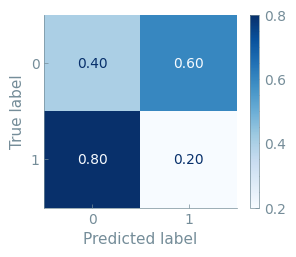

In [69]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_sensorStability_confusionMatrix_50_50_120ep_size15_XGBoost.pdf', bbox_inches='tight')